### Problem Description
Insurance companies take risks over customers. Risk management is a very important aspect of the insurance industry. Insurers consider every quantifiable factor to develop profiles of high and low insurance risks. Insurers collect vast amounts of information about policyholders and analyze the data.

As a Data scientist in an insurance company, you need to analyze the available data and predict whether to sanction the insurance or not.

### Dataset Description
A zipped file containing train, test and sample submission files are given. The training dataset consists of data corresponding to 52310 customers and the test dataset consists of 22421 customers. Following are the features of the dataset

Target: Claim Status (Claim)

Name of agency (Agency)

Type of travel insurance agencies (Agency.Type)

Distribution channel of travel insurance agencies (Distribution.Channel)

Name of the travel insurance products (Product.Name)

Duration of travel (Duration)

Destination of travel (Destination)

Amount of sales of travel insurance policies (Net.Sales)

The commission received for travel insurance agency (Commission)

Age of insured (Age)

The identification record of every observation (ID)

Evaluation Metric
The evaluation metric for this task will be precision_score. Read up about it more here.

### Submission Format
The user has to submit a csv file with the ID and Claim label. Sample submission file has been given to you. You can refer the sample submission file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
from imblearn.over_sampling import SMOTE

In [36]:
path = './data/train.csv'

# Load the dataframe
data = pd.read_csv(path,delimiter=',')

# Remove the Id column from the dataset
# data.drop('Id',axis=1,inplace=True)

print('Shape of the data is: ',data.shape)

data.head()

Shape of the data is:  (52310, 11)


,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


In [37]:
data.drop(['ID','Age'],1, inplace = True)
data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Claim
0,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,0
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,0
4,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 9 columns):
Agency                  52310 non-null object
Agency Type             52310 non-null object
Distribution Channel    52310 non-null object
Product Name            52310 non-null object
Duration                52310 non-null int64
Destination             52310 non-null object
Net Sales               52310 non-null float64
Commision (in value)    52310 non-null float64
Claim                   52310 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 3.6+ MB


In [39]:
data.describe()

,Duration,Net Sales,Commision (in value),Claim
count,52310.000000,52310.000000,52310.000000,52310.000000
mean,58.256108,48.554673,12.219963,0.166699
std,109.138708,60.198589,22.847645,0.372710
min,-2.000000,-389.000000,0.000000,0.000000
25%,10.000000,19.800000,0.000000,0.000000
50%,24.000000,29.500000,0.000000,0.000000
75%,57.000000,55.000000,13.380000,0.000000
max,4881.000000,682.000000,262.760000,1.000000


In [40]:
# Predictors
X = data.iloc[:,:-1]

# Target
y = data.iloc[:,-1]

### Remove Outlier is not helpful here

In [41]:
# Function to detect outliers in every feature
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns=['Feature','Number of Outliers','Percentage','Fence Low','Fence High'])
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            # first quartile (Q1)
            q1 = dataframe[column].quantile(0.25) 
            
            # third quartile (Q3)
            q3 = dataframe[column].quantile(0.75)
            
            # IQR
            iqr = q3 - q1
            
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column,
                                        'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) 
                                                                           | (dataframe[column] > fence_high)]
                                        .shape[0], 'Percentage':(dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]/len(dataframe))*100,
                                       'Fence Low': fence_low, 'Fence High': fence_high},
                                       ignore_index=True)
    return outliers
temp = detect_outliers(X)
temp


,Feature,Number of Outliers,Percentage,Fence Low,Fence High
0,Duration,5484,10.483655,-60.50,127.50
1,Net Sales,5335,10.198815,-33.00,107.80
2,Commision (in value),6394,12.223284,-20.07,33.45


In [42]:
from scipy.stats.mstats import winsorize
# Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


df = treat_outliers(X)

# Checking for outliers after applying winsorization
detect_outliers(X)

,Feature,Number of Outliers,Percentage,Fence Low,Fence High
0,Duration,5484,10.483655,-60.50,127.50
1,Net Sales,0,0.000000,-33.00,107.80
2,Commision (in value),6394,12.223284,-20.07,33.45


In [43]:
#Treat Skewness
import scipy.stats as scs

features = []
skewness = []
for i in X.select_dtypes(include=np.number).columns:
    features.append(i)
    skewness.append(scs.skew(X[i]))
skewed = pd.DataFrame({'Features':features,'Skewness':skewness})

# If skewness is greater than 1 the feature is highly positively skewed
positively_skewed_variables = skewed[(skewed['Skewness']>1)]

# If the skewness is less than -1 the feature is highly negatively skewed.
negatively_skewed_variables = skewed[(skewed['Skewness']<-1)]

print('Positively Skewed Features \n',positively_skewed_variables)
print('*'*50)
print('Negatively Skewed Features \n',negatively_skewed_variables) 

# Let's remove the skewness in the positively skewed variables by using a log transform
for i in positively_skewed_variables['Features']:
     X[i] = np.log1p(X[i])
        
# Checking for outliers after applying winsorization
detect_outliers(X)

Positively Skewed Features 
                Features  Skewness
0              Duration  1.232835
1             Net Sales  1.014536
2  Commision (in value)  1.396855
**************************************************
Negatively Skewed Features 
 Empty DataFrame
Columns: [Features, Skewness]
Index: []


In [46]:
le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
data = dummyEncode(data)


In [8]:
# Predictors
X = data.iloc[:,:-1]

# Target
y = data.iloc[:,-1]

In [9]:
#Check for Class Imbalance
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(y)

0    83.330147
1    16.669853
Name: Claim, dtype: float64

In [21]:
# Model selection and give best 
f1 = []
pc = []
def run_model(predictors,target, model):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
    print('Train Accuracy:\n',model.score(X_train,y_train))
    print('Validation Accuracy:\n',model.score(X_test,y_test))
    print('Classification Report:\n',classification_report(y_test, y_scores))
    print("Precision Score : ",precision_score(y_test, y_scores,average='micro'))
    print("Recall Score : ",recall_score(y_test, y_scores,average='micro'))

    # calculating the f1 score for the validation set
    print("F1 score :", f1_score(y_test, y_scores,average='micro'))
    f1.append(f1_score(y_test, y_scores,average='micro'))
    pc.append(precision_score(y_test, y_scores,average='micro'))
    print("="*120)
    return f1, pc


# Predictors
X = data.iloc[:,:-1]

# Target
y = data.iloc[:,-1]
models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
         }

j = 0
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a, b = run_model(X, y, model)
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))
print('Max Precision Score is {} in model {}'.format(max(b),list(models.keys())[b.index(max(b))]))

================================================== Logistic Regression ==================================================
Train Accuracy:
 0.8447476581915504
Validation Accuracy:
 0.8488816669852801
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.97      0.91      8763
          1       0.59      0.22      0.32      1699

avg / total       0.82      0.85      0.82     10462

Precision Score :  0.8488816669852801
Recall Score :  0.8488816669852801
F1 score : 0.8488816669852801
================================================== Decision Tree ==================================================
Train Accuracy:
 0.9761517874211432
Validation Accuracy:
 0.9174154081437583
Classification Report:
              precision    recall  f1-score   support

          0       0.95      0.95      0.95      8763
          1       0.74      0.75      0.75      1699

avg / total       0.92      0.92      0.92     10462

Precision Score :  0.917415

In [51]:
X.shape

(52310, 8)

In [60]:
# Using RFE for feature selection

def feature_selection(predictors,target,number_of_features,model):

    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
    plt.show()
    print('Features  to be selected for {} are:'.format(str(i[0])))
    print(feature_ranking[feature_ranking.values==1].index.tolist())
    print('===='*30)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
# models = {'Logistic Regression':LogisticRegression,'Random Forest':RandomForestClassifier,'XGBoost':XGBClassifier}
models = {'Logistic Regression':LogisticRegression
          ,'Decision Tree':DecisionTreeClassifier
          ,'Random Forest': RandomForestClassifier
         }
# Selecting 8 number of features
for i in models.items():
    feature_selection(X,y,5,i[1])

Features  to be selected for Logistic Regression are:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Commision (in value)']
Features  to be selected for Decision Tree are:
['Agency', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)']
Features  to be selected for Random Forest are:
['Agency', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)']


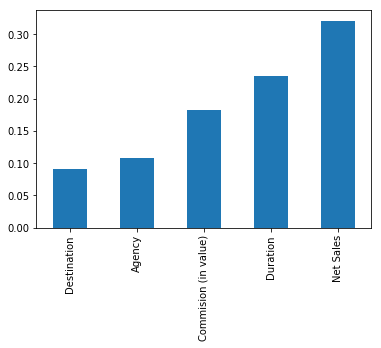

In [59]:
def rfc_feature_selection(dataset,target):
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42, stratify=target)
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    rfc_importances = pd.Series(rfc.feature_importances_, index=dataset.columns).sort_values().tail(5)
    rfc_importances.plot(kind='bar')
    plt.show()

rfc_feature_selection(X,y)

In [61]:
def grid_search_random_forrest(dataframe,target):

    x_train,x_val,y_train,y_val = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
    grid_search_model.fit(x_train, y_train)
    print('Best Parameters are:')
    return grid_search_model.best_params_

grid_search_random_forrest(X,y)

Best Parameters are:


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2'}

In [65]:
def grid_search_XGboost(dataframe,target):

    x_train,x_val,y_train,y_val = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    
    param_grid = { 
    'learning_rate':[0.7,0.8],
    'gamma': [0.7,0.8],
    'max_depth' : [6,8],
    'scale_pos_weight' : [0.4,0.7]
    }
    rfc = RandomForestClassifier(criterion='gini', max_depth= 8, max_features= 'log2')
    xgbc = XGBClassifier(base_estimator=rfc, random_state=42)
    grid_search_model = GridSearchCV(xgbc, param_grid=param_grid)
    grid_search_model.fit(x_train, y_train)
    print('Best Parameters are:')
    return grid_search_model.best_params_


grid_search_XGboost(X,y)

Best Parameters are:


{'gamma': 0.7, 'learning_rate': 0.8, 'max_depth': 8, 'scale_pos_weight': 0.7}

In [68]:
def XGboost(dataframe,target):
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)
 
    global xgbc
    rfc_clf=RandomForestClassifier()
    xgbc = XGBClassifier(base_estimator=rfc_clf, random_state=42, learning_rate=0.8, gamma=0.7, max_depth=8, scale_pos_weight=0.7)
    xgbc.fit(x_train, y_train)
    y_pred=xgbc.predict(x_val)
    precision=precision_score(y_val,y_pred)
    return precision

#trainning
precision = XGboost(X,y)    
print('score is:',precision)



score is: 0.8573369565217391


In [70]:
def XGboost(dataframe,target):
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)
 
    global xgbc
    rfc_clf=RandomForestClassifier()
    xgbc = XGBClassifier(base_estimator=rfc_clf, random_state=42, learning_rate=0.7,gamma=0.7,max_depth=8,scale_pos_weight=0.4)
    xgbc.fit(x_train, y_train)
    y_pred=xgbc.predict(x_val)
    precision=precision_score(y_val,y_pred)
    return precision

#trainning
precision = XGboost(X,y)    
print('score is:',precision)



score is: 0.9061913696060038


In [69]:
def XGboost(dataframe,target):
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)
 
    global xgbc
    rfc_clf=RandomForestClassifier()
    xgbc = XGBClassifier(base_estimator=rfc_clf, random_state=42, learning_rate=0.8, gamma=0.7, max_depth=8, scale_pos_weight=0.1)
    xgbc.fit(x_train, y_train)
    y_pred=xgbc.predict(x_val)
    precision=precision_score(y_val,y_pred)
    return precision

#trainning
precision = XGboost(X,y)    
print('score is:',precision)



score is: 0.97911227154047


Confusion Matrix:
[[12789   292]
 [  566  2046]]
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97     13081
          1       0.88      0.78      0.83      2612

avg / total       0.94      0.95      0.94     15693

ROC_AUC_SCORE is 0.8804926788476513


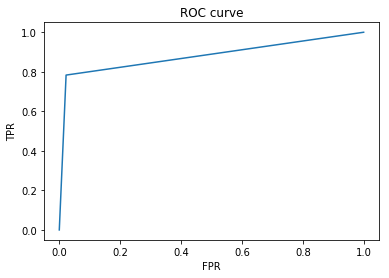

score is: 0.8751069289991446
0    19107
1     3314
Name: Claim, dtype: int64


In [73]:
#importing reqired libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('./data/train.csv')

#removing ID column
data.drop(columns=['ID'],axis=1,inplace=True)
data.head()

#checking for class imbalance 
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values
class_imbalance(data['Claim'])


#label encoding the data
le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
data = dummyEncode(data)

#predictors for training
X = data.iloc[:,:-1]

# Target
y = data.iloc[:,-1]


def XGboost(dataframe,target):
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)

    global xgbc
    rfc_clf=RandomForestClassifier(criterion='gini', max_depth= 8, max_features= 'log2')
    xgbc = XGBClassifier(base_estimator=rfc_clf,random_state=42,learning_rate=0.7,gamma=0.7,max_depth=8,scale_pos_weight=0.7)
    xgbc.fit(x_train, y_train)
    y_pred=xgbc.predict(x_val)
    precision=precision_score(y_val,y_pred)
    print('Confusion Matrix:')
    print(confusion_matrix(y_val,y_pred))  
    print('Classification Report:')
    print(classification_report(y_val,y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return precision

#trainning
precision = XGboost(X,y)    
print('score is:',precision)

#testing function
def prediction(test):
    y_pred = xgbc.predict(test)
    
    return y_pred

test=pd.read_csv('./data/test.csv')

# Storing the Id column
Id = test[['ID']]

# Preprocessed Test File
test.drop('ID',1,inplace=True)
test.head()
#label encoder
test = dummyEncode(test)
test.head()

#predicting on test file
y_pred = pd.DataFrame(prediction(test),columns=['Claim']) 
print(y_pred['Claim'].value_counts())
submission = pd.concat([Id,y_pred['Claim']],1)
# submission.to_csv('submission.csv',index=False)